In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from joblib import dump, load
from sklearn.metrics import accuracy_score, f1_score, precision_score,recall_score,confusion_matrix
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import metrics

from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt
from  sklearn.preprocessing import *
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics
import tensorflow as tf

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
import pandas as pd
import numpy as np
import sys
import keras
import os
import glob
import sklearn
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM, SimpleRNN, GRU, Bidirectional, BatchNormalization,Convolution1D,MaxPooling1D, Reshape, GlobalAveragePooling1D
from keras.utils import to_categorical
import sklearn.preprocessing
from sklearn import metrics
from scipy.stats import zscore
from tensorflow.keras.utils import get_file, plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
print(pd.__version__)
print(np.__version__)
print(sys.version)
print(sklearn.__version__)


In [ ]:
#Loading training set into dataframe
df = pd.read_csv('nsl-kdd/KDDTrain+.txt', header=None)
df.head()

In [ ]:
#Loading testing set into dataframe
qp = pd.read_csv('nsl-kdd/KDDTest+.txt', header=None)
qp.head()

In [ ]:
#Reset column names for training set
df.columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
'num_access_files', 'num_outbound_cmds', 'is_host_login',
'is_guest_login', 'count', 'srv_count', 'serror_rate',
'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
'dst_host_srv_count', 'dst_host_same_srv_rate','dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate', 'subclass', 'difficulty_level']
df.head()


In [ ]:
#Reset column names for testing set
qp.columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
'num_access_files', 'num_outbound_cmds', 'is_host_login',
'is_guest_login', 'count', 'srv_count', 'serror_rate',
'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
'dst_host_srv_count', 'dst_host_same_srv_rate','dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate', 'subclass', 'difficulty_level']
qp.head()

In [ ]:
#accessing names of training columns
lst_names = df.columns # returns a list of column names
lst_names

In [ ]:
#accessing names of testing columns
testlst_names = qp.columns
testlst_names

In [ ]:
#Dropping the last columns of training set
df = df.drop('difficulty_level',axis=1) # we don't need it in this project
df.shape

In [ ]:
#Dropping the last columns of testing set
qp = qp.drop('difficulty_level', axis=1)
qp.shape

In [ ]:
# null values check for training set 
df.isnull().values.any()

In [ ]:
# null values check for testing set 
qp.isnull().values.any()

In [ ]:
#defining col list
cols = ['protocol_type','service','flag']
cols

In [ ]:
#One-hot encoding
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
        try :  
            df = df.drop(each,axis=1)
        except Exception :
            print ("column " + each + " can't be dropped")
    return df


In [ ]:
#Merging train and test data
combined_data = pd.concat([df,qp])

In [ ]:
#Applying one hot encoding to combined data
combined_data = one_hot(combined_data,cols)

In [ ]:
print(combined_data.columns[:50])
#print(combined_data.columns[50:100])
print(combined_data.columns[100:150])
#print(combined_data.columns[150:])


In [ ]:
#Function to min-max normalize
def normalize(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with normalized specified features
    """
    result = df.copy() # do not touch the original df
    for feature_name in cols:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        print( min_value, max_value)
        
        if max_value > min_value:
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [ ]:
combined_data.shape

In [ ]:
#Dropping subclass column for training set
tmp = combined_data.pop('subclass')


In [ ]:
#Normalizing training set
new_train_df = normalize(combined_data.astype(float),combined_data.columns)

In [ ]:
#Fixing labels for training set
classlist = []
check1 = ("apache2","back","land","neptune","mailbomb","pod","processtable","smurf","teardrop","udpstorm","worm")
check2 = ("ipsweep","mscan","nmap","portsweep","saint","satan")
check3 = ("buffer_overflow","loadmodule","perl","ps","rootkit","sqlattack","xterm")
check4 = ("ftp_write","guess_passwd","httptunnel","imap","multihop","named","phf","sendmail","Snmpgetattack","spy","snmpguess","warezclient","warezmaster","xlock","xsnoop")

DoSCount=0
ProbeCount=0
U2RCount=0
R2LCount=0
NormalCount=0

for item in tmp:
    if item in check1:
        classlist.append("DoS")
        DoSCount=DoSCount+1
    elif item in check2:
        classlist.append("Probe")
        ProbeCount=ProbeCount+1
    elif item in check3:
        classlist.append("U2R")
        U2RCount=U2RCount+1
    elif item in check4:
        classlist.append("R2L")
        R2LCount=R2LCount+1
    else:
        classlist.append("Normal")
        NormalCount=NormalCount+1   

In [ ]:
#Appending class column to training set
new_train_df["Class"] = classlist
new_train_df

In [ ]:
new_train_df["Class"].value_counts()

In [ ]:
import shutil

def split_nodes_datasets(train_df,nb_clients,frac_train_test=0.80):

    y_train=train_df["Class"]
    combined_data_X_main = train_df
    
    label_encoder=LabelEncoder()
    label_encoder.fit(y_train)

    if os.path.isdir("clients"):
        shutil.rmtree("clients")
    os.mkdir("clients")

    N =  combined_data_X_main.shape[0]
    nb_sets=nb_clients 

    combined_data_X=combined_data_X_main.sample(frac=frac_train_test)
    test_data = combined_data_X_main.drop(combined_data_X.index)
    
    y_test = label_encoder.transform(test_data["Class"])
    x_test = test_data.drop("Class",axis=1)

    N =  combined_data_X.shape[0]
    nb_sets=nb_clients 
    y_train=combined_data_X["Class"]
    combined_data_X=combined_data_X.drop("Class",axis=1)


    for i in range(0,nb_clients) : 
        os.mkdir("clients/client_"+str(i))

    datafolders=glob.glob("clients/*")  
    y_train=pd.DataFrame(label_encoder.transform(y_train))
    for i, datafolder in enumerate(datafolders):

        begin_train_index= int((i)/nb_sets * N)
        begin_val_index= int( (i+0.8)/nb_sets*N)
        end_val_index= int((i+1)/nb_sets*N)
        
        combined_data_X.iloc[begin_train_index:begin_val_index].to_hdf(datafolder+"/train.hdf5",key="set_x",mode="a")
        combined_data_X.iloc[begin_val_index:end_val_index].to_hdf(datafolder+"/val.hdf5",key="set_x",mode="a")
        y_train.iloc[begin_train_index:begin_val_index].to_hdf(datafolder+"/train.hdf5",key="set_y",mode="a")
        y_train.iloc[begin_val_index:end_val_index].to_hdf(datafolder+"/val.hdf5",key="set_y",mode="a")


    return x_test,y_test,label_encoder



In [ ]:
# Reccurent NN

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
def RNNModel(input_shape=(122,),output_shape=5,hidden_layers=None):

        #Bidirectional RNN
    model_rnn = Sequential()
    model_rnn.add(Convolution1D(64, kernel_size=50,activation="relu",input_shape=(input_shape[0], 1)))
    model_rnn.add(MaxPooling1D(pool_size=(5)))
    model_rnn.add(BatchNormalization())
    model_rnn.add(Bidirectional(LSTM(64, return_sequences=False))) 
    model_rnn.add(Reshape((128, 1), input_shape = (128, )))
    
    model_rnn.add(MaxPooling1D(pool_size=(5)))
    model_rnn.add(BatchNormalization())
    model_rnn.add(Bidirectional(LSTM(128, return_sequences=False))) 
    
    model_rnn.add(Dropout(0.5))
    model_rnn.add(Dense(output_shape))
    model_rnn.add(Activation('softmax'))
    model_rnn.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer='adam',metrics=['accuracy'])
    return model_rnn

# MPL model
def MLPModel(input=(122,),output=5,hidden_layers=[16,16]):
    model_mlp = Sequential()
    model_mlp.add(Dense(hidden_layers[0],input_shape=input,activation="relu"))
    for hl in hidden_layers[1:]:
        model_mlp.add(Dense(hl,activation="relu"))
    model_mlp.add(Dense(output,activation="softmax"))
    model_mlp.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer='adam',metrics=['accuracy'])
    return model_mlp


In [ ]:
import glob
import functools
import copy




def init_nodes(data_folders):

    nodes =  {datafolder.split("/")[-1]: {"model": None\
                       ,"train_set":{"set_x": pd.read_hdf(datafolder+"/"+"train.hdf5","set_x")\
                                     ,"set_y": pd.read_hdf(datafolder+"/"+"train.hdf5","set_y")}\
                       ,"val_set": {"set_x": pd.read_hdf(datafolder+"/"+"val.hdf5","set_x"),\
                                     "set_y": pd.read_hdf(datafolder+"/"+"val.hdf5","set_y")}\
                        } for datafolder in data_folders}
    return nodes

def set_model(nodes,model): 
      for node in nodes.keys():
        nodes[node]["model"]=model
   
def train_nodes(nodes,epochs=5,batchsize=32):
    history = LossHistory()
    for node in nodes.keys(): 
        print("training    " ,node ,':  \n ==========================================')
        train_x_set= nodes[node]["train_set"].get("set_x")
        train_y_set= nodes[node]["train_set"].get("set_y")
        nodes[node]['model'].fit(x=train_x_set,y=train_y_set,batch_size=batchsize,epochs=epochs, verbose=0, validation_split=0.1,callbacks=[history])
        nodes[node]['losses'] = history.losses

def eval(model,x_set,y_set):
    predictions=model.predict(x_set)
    y_hat=predictions.argmax(axis=1)
    nb_classes=predictions.shape[1]
    y_set_one_hote=np.eye(nb_classes)[y_set] 
    print(predictions.shape,y_set_one_hote.shape)
    scores = {"confusion_matrix": confusion_matrix(y_set ,y_hat)\
                       ,'f1_score': f1_score(y_set,y_hat,average="macro")\
                        ,"accuracy_score": accuracy_score(y_set,y_hat)\
                        , "precision_score" : precision_score(y_set,y_hat,average="macro")
                        ,"recall_score" : recall_score(y_set,y_hat,average="macro")
                        ,"roc_curve":{"classes":{ i :  roc_curve(y_set_one_hote[:,i],predictions[:,i]) for i in range(nb_classes)}}
                    }
    


    scores["roc_curve"]["micro_average_roc_curve"]=roc_curve(y_set_one_hote.ravel(),predictions.ravel())

    
    fpr_grid = np.linspace(0.0, 1.0, 200)

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for fpr,tpr,tr in scores["roc_curve"]["classes"].values() :
        mean_tpr += np.interp(fpr_grid, fpr, tpr)  # linear interpolation

    # Average it and compute AUC
    mean_tpr /= len(scores["roc_curve"]["classes"])
    
    scores["roc_curve"]["macro_average_roc_curve"] = (fpr_grid,mean_tpr)

    return scores 

def eval_nodes(nodes,main_model=None):
    for node in nodes.keys():
        print("evealuating    " , node ,':  \n ==========================================')
        model = nodes[node]['model'] if main_model==None else main_model
        model_scores= "self_scores" if main_model==None else "main_model_scores"
        y_set=nodes[node]["val_set"].get("set_y").to_numpy().reshape(-1)    
        nodes[node][model_scores]= eval(model,nodes[node]["val_set"].get("set_x"),y_set)
        nodes[node][model_scores]["loss"]= nodes[node].get("losses")[-1] if nodes[node].get("losses")!=None else None


    
def agg_wieghts(nodes):
    
    weights = list(map(lambda node : (node['train_set'].get('set_y').size, node['model'].get_weights()),nodes.values()))
    weights.insert(0,(1,list(map(lambda w : np.zeros_like(w),weights[0][1]))))
    total,weights_sum = functools.reduce(lambda s1,s2 : (s1[0]+s2[0], list(map(lambda x: x[0]+x[1]*s2[0] ,zip(s1[1],s2[1])) )),weights)
    return list(map(lambda x:  x/total, weights_sum))


def fed_train(server,nodes,rounds=10,epochs=5,batchsize=32,resutl_save_frequency=2):
    best_f1 = 0
    best_model= copy.deepcopy(next(iter(nodes.values()))["model"])
    server["server"]["rounds_scores"]={}
    for node in nodes.values(): 
                node["rounds_scores"]={}


    for r in range(1,rounds+1): 
        print('step ', r,' :  \n\n ======================================================================')
        
        
        train_nodes(nodes,batchsize=batchsize,epochs=epochs)
        server["server"]["model"].set_weights(agg_wieghts(nodes))
        eval_nodes(server)
        print( "======================================================================",best_f1 ,server['server']["self_scores"]["f1_score"])
        if server['server']["self_scores"]["f1_score"] > best_f1 :
            print("update best model")
            best_model.set_weights(server['server']["model"].get_weights())
            best_f1 = server['server']["self_scores"]["f1_score"]
        else :
            server['server']["model"].set_weights(best_model.get_weights())

        for node in nodes.values() : 
            node["model"].set_weights(best_model.get_weights()) 
            
                  
        print("server model scores  : \n",server['server']['self_scores'])

        if r % resutl_save_frequency == 0 :
            eval_nodes(nodes)
            server['server']['rounds_scores'][r]=server['server']['self_scores']
            for node in nodes.values(): 
                node["rounds_scores"][r]=node['self_scores']
        
    

def plot_mytric_by_round(rounds_scores,label_encoder=None) : 
    
    nb_metrics=len(next(iter(rounds_scores.values())))-2
    metrics_axes_index= list(range(nb_metrics))
    metrics_fig, metrics_axs = plt.subplots(1, nb_metrics, figsize=(nb_metrics*7, 7))
    class_labels = label_encoder.inverse_transform(list(next(iter(rounds_scores.values()))["roc_curve"]["classes"].keys())) 
    for i,metric in enumerate(next(iter(rounds_scores.values())).keys()):
        if not next(iter(rounds_scores.values())).get(metric) is  None : 
            if metric == "roc_curve" : 
                roc_fig , roc_axs = plt.subplots(1, len(rounds_scores), figsize=(len(rounds_scores)*7,7))
                for i,(r,scores) in  enumerate(rounds_scores.items()):
                    roc_curves=scores["roc_curve"]['classes']
                    ax=roc_axs[i]
                    ax.set_xlabel("False Positive Rate")
                    ax.set_ylabel("True Positive Rate")
                    ax.set_yticks(np.arange(0,1,0.05))
                    ax.set_title("Roc Curves for round "+ str(r))
                  
                    
                    for i,roc_curv_values in enumerate(roc_curves.values()):
                        fpr, tpr, thresholds =roc_curv_values
                        ax.plot(fpr, tpr,label= 'roc_{}_(area = {:2f})'.format(class_labels[i],auc(fpr, tpr)))
                    
                    
                    fpr, tpr, _ =scores["roc_curve"]["micro_average_roc_curve"]
                    ax.scatter(fpr, tpr,label= 'roc_{}_(area = {:2f})'.format("micro_average",auc(fpr, tpr)),s=10)
                    
                    fpr, tpr  = scores["roc_curve"]["macro_average_roc_curve"]
                    ax.scatter(fpr, tpr,label= 'roc_{}_(area = {:2f})'.format("macro_average",auc(fpr, tpr)),s=10)

                    ax.legend()
                    plt.setp(ax.get_yticklabels(),visible=True)
                    continue

            elif metric == "confusion_matrix" :
                matrixes_fig , maxtrixes_axs = plt.subplots(1, len(rounds_scores), figsize=(len(rounds_scores)*7,7))
                for i,(r,scores) in  enumerate(rounds_scores.items()):
                    conf_matrix=scores["confusion_matrix"]
                    ax=maxtrixes_axs[i]
                    sns.heatmap(conf_matrix,ax=ax,annot=True,fmt='d',xticklabels=class_labels,yticklabels=class_labels)
                
                    ax.set_xlabel("Predicted")
                    ax.set_ylabel("Truth")
                    ax.set_title("Confustion Matrix at round "+str(r))  
                    ax.legend()
                    plt.setp(ax.get_yticklabels(),visible=True)
                    continue
            else:
                i = metrics_axes_index.pop()
                ax=metrics_axs[i]
                ax.set_xlabel("round")
                ax.set_ylabel(metric)
                ax.set_yticks(np.arange(0,1,0.02))
                ax.set_title( metric + " evolution by rounds ")
                x = list(rounds_scores.keys())
                y = list(map(lambda x: x[metric],rounds_scores.values()))
                ax.plot(x,y,label=metric)
                ax.scatter(x,y)
                plt.setp(ax.get_yticklabels(),visible=True)
                ax.legend()



    
    
    metrics_fig.suptitle("metrics evolution by round")
    metrics_fig.show()
        
    roc_fig.suptitle("Roc Curves by round")    
    roc_fig.show()

    matrixes_fig.suptitle("metrics evolution by round")
    matrixes_fig.show()


def main(dataframe,nb_clients=4,rounds=10,batchsize=128,epochs=5,model=MLPModel,hidden_layers=[5,5],input_shape=(122,),output_shape=5,resutl_save_frequency=2,frac_train_test=0.8) :
    #create clients data set
    x_test,y_test,label_encoder = split_nodes_datasets(dataframe,nb_clients,frac_train_test=frac_train_test)
    
    #get list of clients
    datafolders=glob.glob("clients/*")

    #initialise clients with their dataset
    clients=init_nodes(datafolders)

    #initialise server
    server={'server':{'model': None ,'val_set':{"set_x":  pd.DataFrame(x_test),"set_y":pd.DataFrame(y_test)}}}



    set_model(clients,model(input_shape,output_shape,hidden_layers))
    set_model(server,model(input_shape,output_shape,hidden_layers))

    for i in server.keys():
        print(server[i])
    fed_train(server,clients,rounds,epochs,batchsize,resutl_save_frequency)


    return clients,server,label_encoder



In [ ]:
clients,server,label_encoder=main(new_train_df,nb_clients=30,rounds=5,batchsize=32,epochs=5,model=MLPModel,hidden_layers=[32,16],input_shape=(122,),output_shape=5,resutl_save_frequency=1)

/tmp/ipykernel_660294/92078239.py:187: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  metrics_fig.show()
/tmp/ipykernel_660294/92078239.py:190: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  roc_fig.show()
/tmp/ipykernel_660294/92078239.py:193: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  matrixes_fig.show()


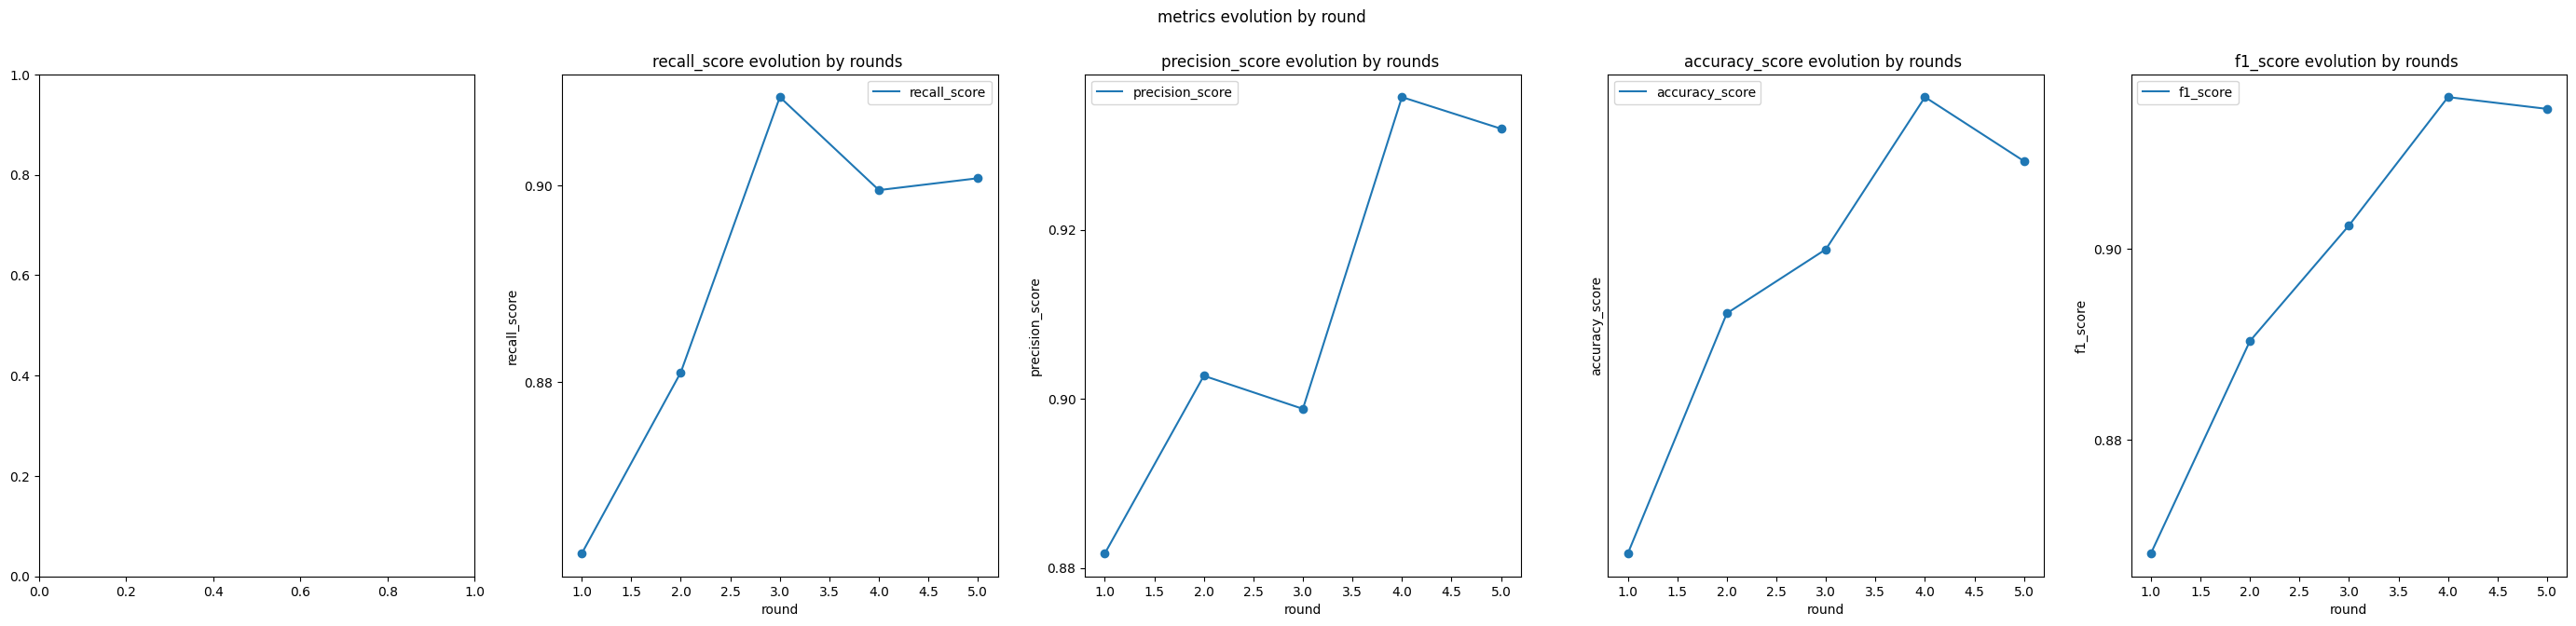

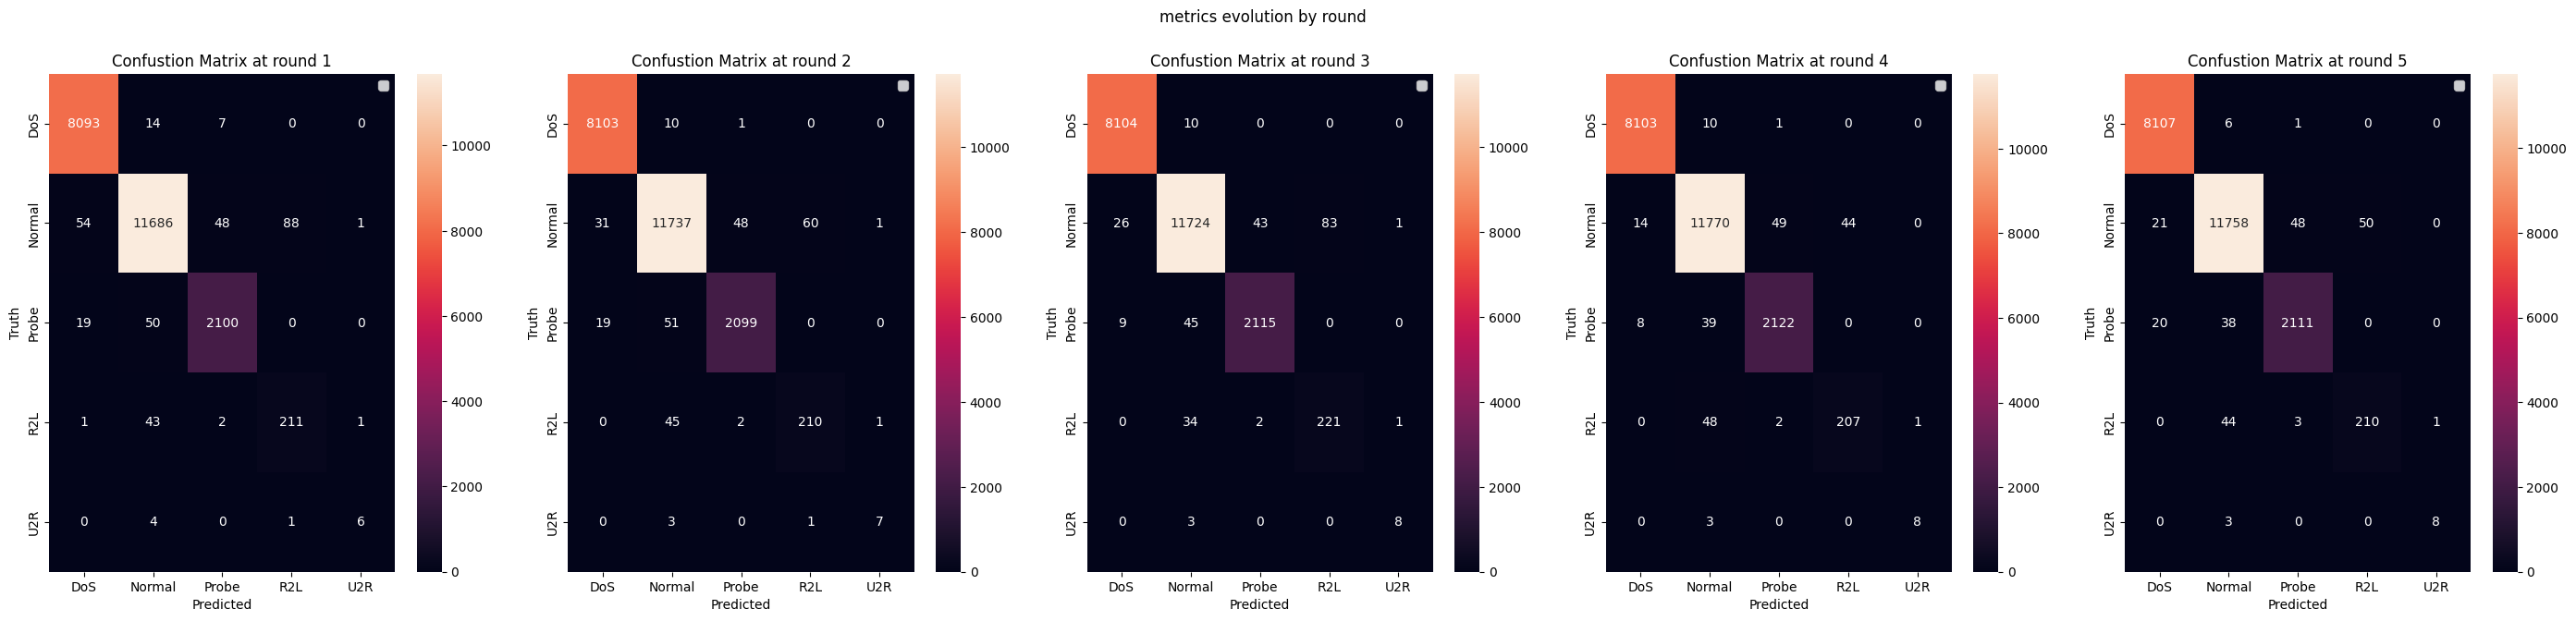

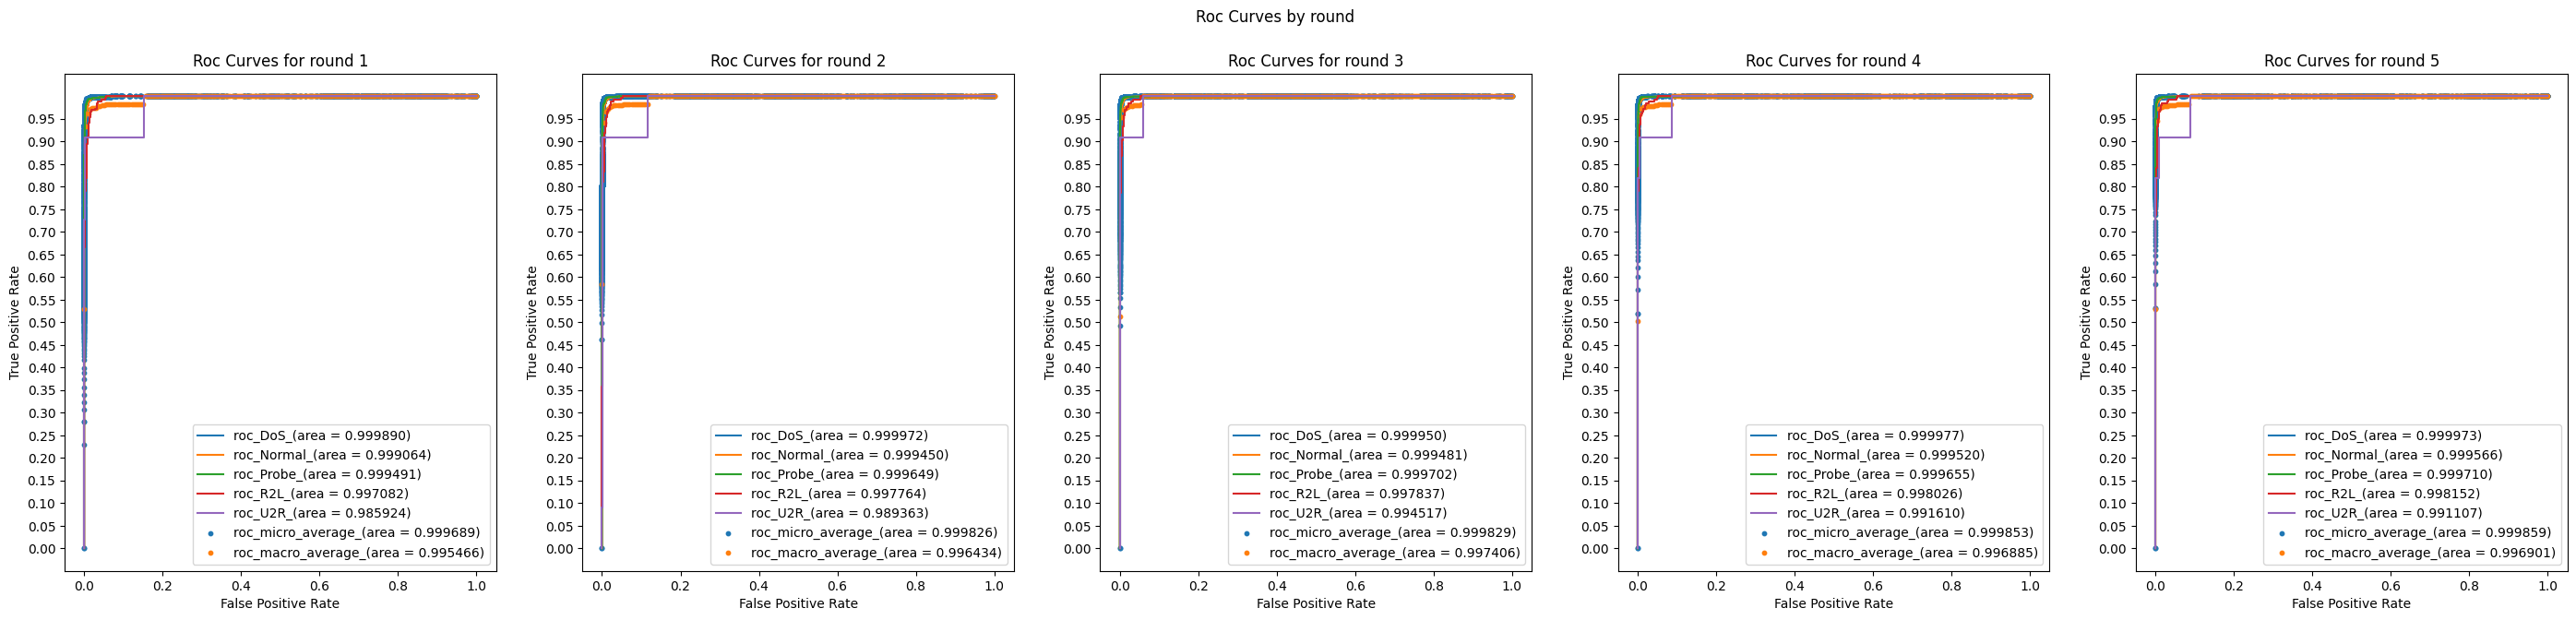

In [34]:
plot_mytric_by_round(server["server"]["rounds_scores"],label_encoder)

/tmp/ipykernel_660294/92078239.py:187: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  metrics_fig.show()
/tmp/ipykernel_660294/92078239.py:190: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  roc_fig.show()
/tmp/ipykernel_660294/92078239.py:193: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  matrixes_fig.show()


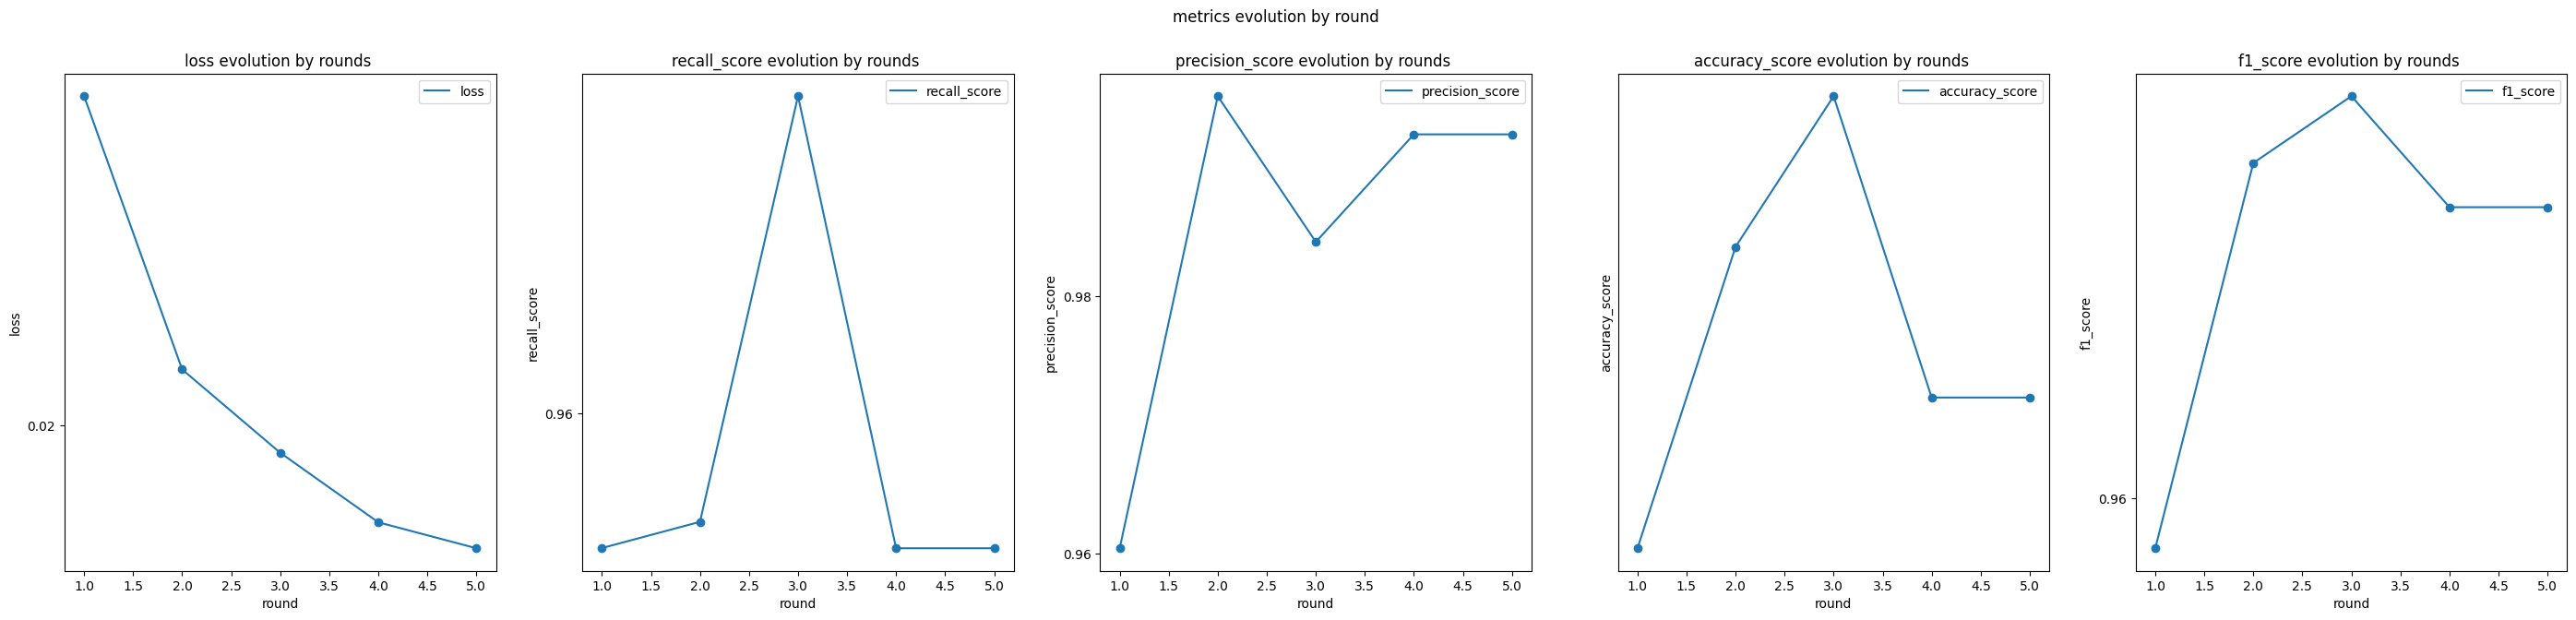

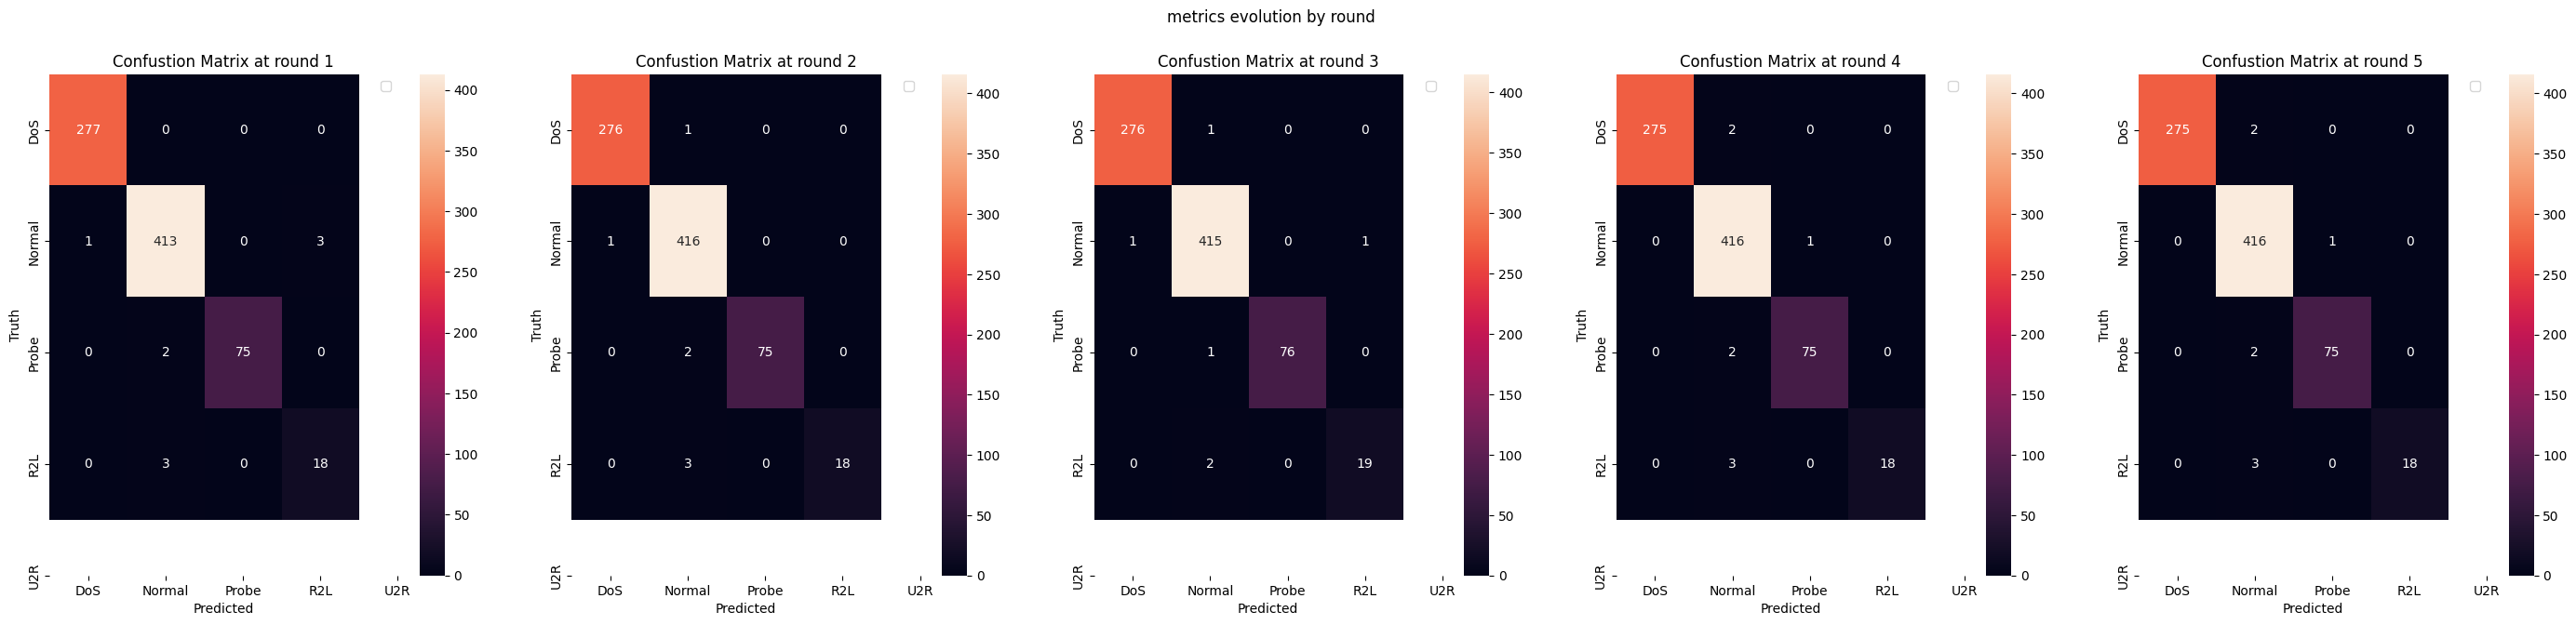

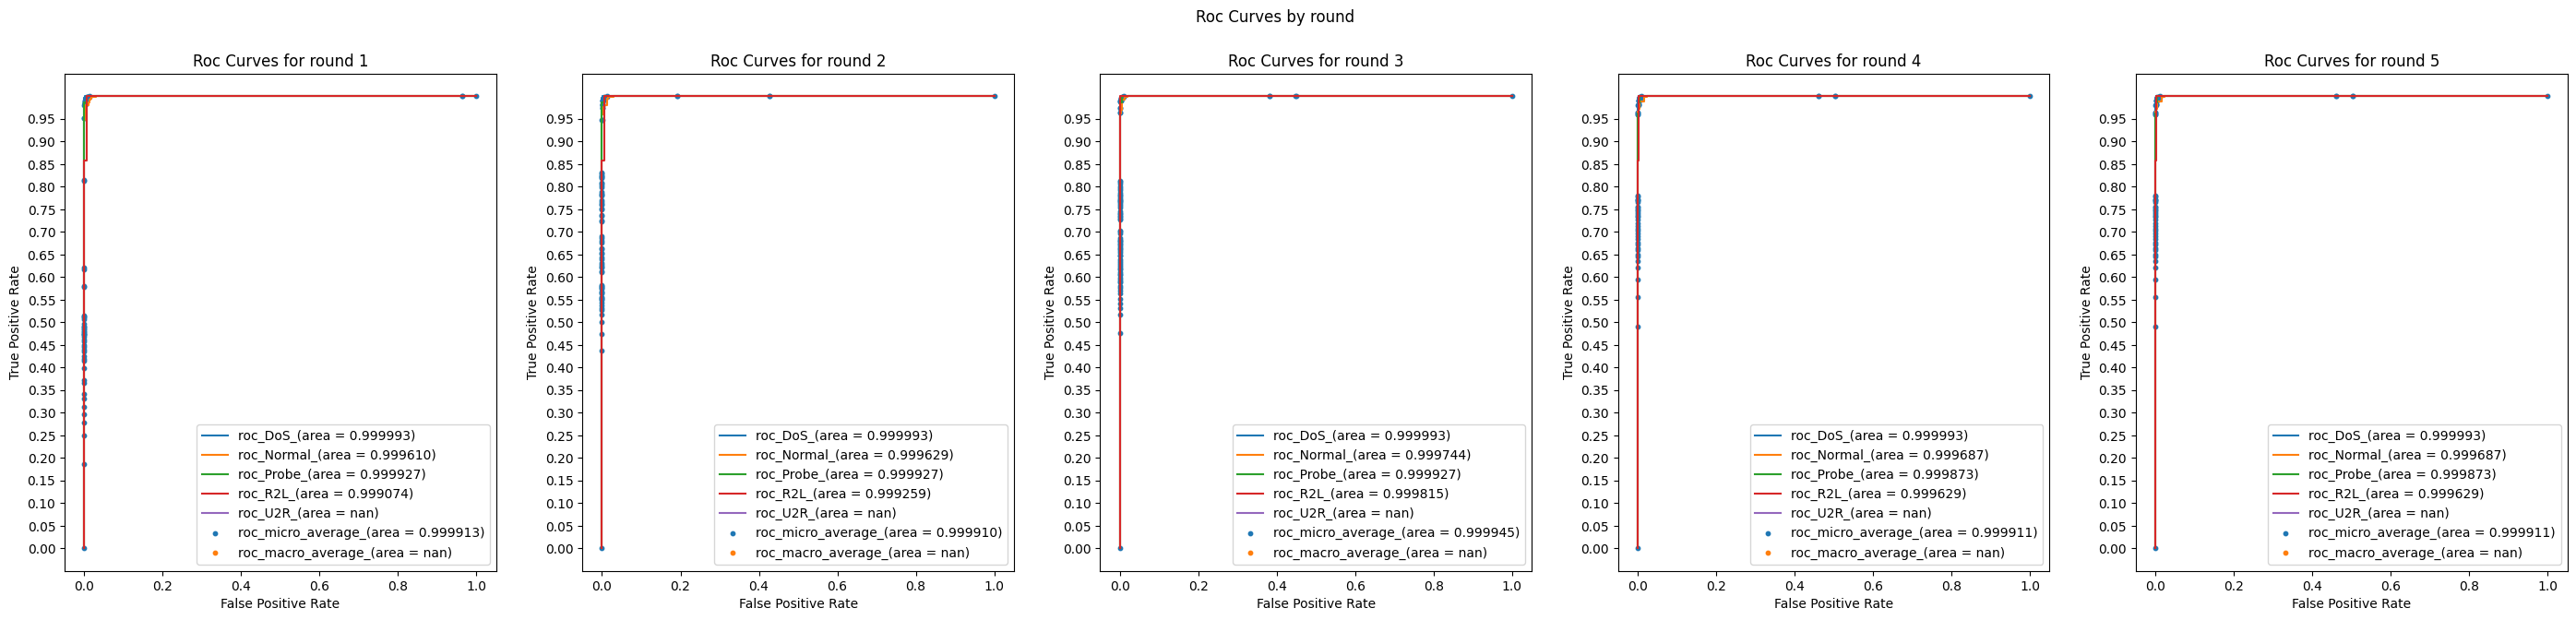

In [35]:
plot_mytric_by_round(clients["client_1"]["rounds_scores"],label_encoder)

In [ ]:
server["server"]["rounds_scores"][2]["roc_curve"].keys()